# An Experimental Study on Breast Ultrasound Tumor Classification



In this Notebook we explore the CNN based classification of Breast US Tumor Images. The main idea is to study the efficiency of benign vs. malignant classification of the images with the help of pretrained Deep CNN models when UNet predicted Tumor Masks are available. Particularly for this notebook, the Ground Truth Tumor Masks are not going to be utilized for the purpose of classification, but instead automatically predicted masks are going to be utilized.

For the purpose experimentation two publicly available datasets are utilized, 

*   BUSI dataset. (https://www.sciencedirect.com/science/article/pii/S2352340919312181)
*   UDIAT dataset. (https://ieeexplore.ieee.org/abstract/document/8003418)



The dataset images have been preprocessed and converted to 224x224 dimensionality and saved as .npy files. These files will be used directly in this Notebook.

In [1]:
# Connect to Google Drive to access dataset
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
# Check dataset filenames
import os
import cv2

bus_filenames = os.listdir('/content/gdrive/My Drive/BreastUSDatasetNPYs')
print(bus_filenames)

['busiTestImages.npy', 'busiTestLabels.npy', 'busiTestMasks.npy', 'busiTrainImages.npy', 'udTrainImages.npy', 'busiTrainMasks.npy', 'udTestLabels.npy', 'udTestMasks.npy', 'udTestImages.npy', 'busiTrainLabels.npy', 'udTrainLabels.npy', 'udTrainMasks.npy', 'Combined_UNet_Model.h5']


In [3]:
# Read the Numpy files containing the dataset.
import numpy as np

busiTrainImages = np.load('/content/gdrive/My Drive/BreastUSDatasetNPYs/busiTrainImages.npy')
busiTrainMasks = np.load('/content/gdrive/My Drive/BreastUSDatasetNPYs/busiTrainMasks.npy')
busiTrainLabels = np.load('/content/gdrive/My Drive/BreastUSDatasetNPYs/busiTrainLabels.npy')
busiTestImages = np.load('/content/gdrive/My Drive/BreastUSDatasetNPYs/busiTestImages.npy')
busiTestMasks = np.load('/content/gdrive/My Drive/BreastUSDatasetNPYs/busiTestMasks.npy')
busiTestLabels = np.load('/content/gdrive/My Drive/BreastUSDatasetNPYs/busiTestLabels.npy')

udTrainImages = np.load('/content/gdrive/My Drive/BreastUSDatasetNPYs/udTrainImages.npy')
udTrainMasks = np.load('/content/gdrive/My Drive/BreastUSDatasetNPYs/udTrainMasks.npy')
udTrainLabels = np.load('/content/gdrive/My Drive/BreastUSDatasetNPYs/udTrainLabels.npy')
udTestImages = np.load('/content/gdrive/My Drive/BreastUSDatasetNPYs/udTestImages.npy')
udTestMasks = np.load('/content/gdrive/My Drive/BreastUSDatasetNPYs/udTestMasks.npy')
udTestLabels = np.load('/content/gdrive/My Drive/BreastUSDatasetNPYs/udTestLabels.npy')

print(busiTrainImages.shape)
print(busiTrainMasks.shape)
print(busiTrainLabels.shape)
print(busiTestImages.shape)
print(busiTestMasks.shape)
print(busiTestLabels.shape)

print(udTrainImages.shape)
print(udTrainMasks.shape)
print(udTrainLabels.shape)
print(udTestImages.shape)
print(udTestMasks.shape)
print(udTestLabels.shape)

(532, 224, 224)
(532, 224, 224)
(532,)
(133, 224, 224)
(133, 224, 224)
(133,)
(130, 224, 224)
(130, 224, 224)
(130,)
(33, 224, 224)
(33, 224, 224)
(33,)


In [4]:
# Inspect the pixel value range 

print(busiTrainImages[0])
print(busiTrainMasks[0])
print(busiTrainLabels[0])

# The images and also the masks are having pixel values in the range 0-255
# We need to rescale the data to bring all pixel values to the range 0 to 1

busiTrainImages = busiTrainImages/255.
busiTrainMasks = busiTrainMasks/255.

busiTestImages = busiTestImages/255.
busiTestMasks = busiTestMasks/255.

udTrainImages = udTrainImages/255.
udTrainMasks = udTrainMasks/255.

udTestImages = udTestImages/255.
udTestMasks = udTestMasks/255.

[[ 80 174  37 ... 208 207 199]
 [ 83 207  21 ... 195 199 202]
 [ 85 161  42 ... 180 182 186]
 ...
 [ 20  19  16 ...  36  46  54]
 [ 29  27  23 ...  57  53  46]
 [ 20  20  23 ...  37  32  30]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
0


In [5]:
# After rescaling the pixel values are modified
print(busiTrainImages[0])

[[0.31372549 0.68235294 0.14509804 ... 0.81568627 0.81176471 0.78039216]
 [0.3254902  0.81176471 0.08235294 ... 0.76470588 0.78039216 0.79215686]
 [0.33333333 0.63137255 0.16470588 ... 0.70588235 0.71372549 0.72941176]
 ...
 [0.07843137 0.0745098  0.0627451  ... 0.14117647 0.18039216 0.21176471]
 [0.11372549 0.10588235 0.09019608 ... 0.22352941 0.20784314 0.18039216]
 [0.07843137 0.07843137 0.09019608 ... 0.14509804 0.1254902  0.11764706]]


In [6]:
# Get UNet predicted masks
import tensorflow as tf

model  = tf.keras.models.load_model('/content/gdrive/My Drive/BreastUSDatasetNPYs/Combined_UNet_Model.h5', compile=False)
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 224, 224, 64  640         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 dropout (Dropout)              (None, 224, 224, 64  0           ['conv2d[0][0]']                 
                                )                                                             

In [7]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten,Conv2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from sklearn.metrics import confusion_matrix
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D as GAP

from keras.losses import binary_crossentropy
import keras.backend as K


def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred = K.cast(y_pred, 'float32')
    y_pred_f = K.cast(K.greater(K.flatten(y_pred), 0.5), 'float32')
    intersection = y_true_f * y_pred_f
    score = 2. * K.sum(intersection) / (K.sum(y_true_f) + K.sum(y_pred_f))
    return score

def dice_loss(y_true, y_pred):
    y_true = K.cast(y_true, 'float32')
    y_pred = K.cast(y_pred, 'float32')
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f * y_true_f) + K.sum(y_pred_f * y_pred_f) + smooth)
    return 1. - score

def bce_dice_loss(y_true, y_pred):
    y_true = K.cast(y_true, 'float32')
    y_pred = K.cast(y_pred, 'float32')
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

model.compile(optimizer='adam', loss=bce_dice_loss, metrics=[dice_coef])

In [8]:
predBUSITrainMasks = model.predict(busiTrainImages)
predBUSITestMasks = model.predict(busiTestImages)

print(predBUSITrainMasks.shape)
print(predBUSITestMasks.shape)

(532, 224, 224, 1)
(133, 224, 224, 1)


In [9]:
# Blend the predicted masks with the original BUS images to get masked images

maskedImages = list()

# blend with alpha=0.5

busiTrainImages = busiTrainImages.astype(float)
busiTestImages = busiTestImages.astype(float)

predBUSITrainMasks = predBUSITrainMasks.astype(float)
predBUSITestMasks = predBUSITestMasks.astype(float)


for i in range(len(busiTrainImages)):
    img = busiTrainImages[i].reshape(224,224)
    msk = predBUSITrainMasks[i].reshape(224,224)
    maskedImages.append(cv2.addWeighted(img, 0.5, msk, 0.5, 0))


busiTrainImages = np.stack(maskedImages, axis=0)
print(busiTrainImages.shape)

maskedImages = list()

# blend with alpha=0.5

for i in range(len(busiTestImages)):
    img = busiTestImages[i].reshape(224,224)
    msk = predBUSITestMasks[i].reshape(224,224)
    maskedImages.append(cv2.addWeighted(img, 0.5, msk, 0.5, 0))


busiTestImages = np.stack(maskedImages, axis=0)
print(busiTestImages.shape)

(532, 224, 224)
(133, 224, 224)


Visualization of BUS samples

The following are some benign BUS samples...


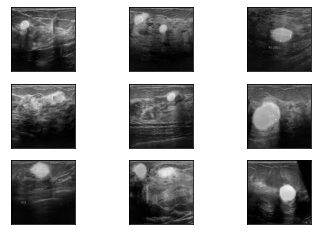

In [10]:
import matplotlib.pyplot as plt

sampleBenignInd = list()
sampleMaligInd = list()
for i in range(len(busiTrainLabels)):
  if busiTrainLabels[i] == 0 and len(sampleBenignInd) < 10:
    sampleBenignInd.append(i)
  elif busiTrainLabels[i] == 1 and len(sampleMaligInd) < 10:
    sampleMaligInd.append(i)
  if len(sampleBenignInd) == 9 and len(sampleMaligInd) == 9:
    break

print('The following are some benign BUS samples...')
fig, axs = plt.subplots(3, 3)
axs[0, 0].imshow(busiTrainImages[sampleBenignInd[0]], cmap='gray')

axs[0, 1].imshow(busiTrainImages[sampleBenignInd[1]], cmap='gray')

axs[0, 2].imshow(busiTrainImages[sampleBenignInd[2]], cmap='gray')

axs[1, 0].imshow(busiTrainImages[sampleBenignInd[3]], cmap='gray')

axs[1, 1].imshow(busiTrainImages[sampleBenignInd[4]], cmap='gray')

axs[1, 2].imshow(busiTrainImages[sampleBenignInd[5]], cmap='gray')

axs[2, 0].imshow(busiTrainImages[sampleBenignInd[6]], cmap='gray')

axs[2, 1].imshow(busiTrainImages[sampleBenignInd[7]], cmap='gray')

axs[2, 2].imshow(busiTrainImages[sampleBenignInd[8]], cmap='gray')



# remove the x and y ticks
for ax in axs.flat:
    ax.set_xticks([])
    ax.set_yticks([])

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

The following are some malignant BUS samples...


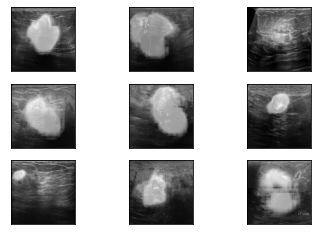

In [11]:
print('The following are some malignant BUS samples...')

fig, axs = plt.subplots(3, 3)
axs[0, 0].imshow(busiTrainImages[sampleMaligInd[0]], cmap='gray')

axs[0, 1].imshow(busiTrainImages[sampleMaligInd[1]], cmap='gray')

axs[0, 2].imshow(busiTrainImages[sampleMaligInd[2]], cmap='gray')

axs[1, 0].imshow(busiTrainImages[sampleMaligInd[3]], cmap='gray')

axs[1, 1].imshow(busiTrainImages[sampleMaligInd[4]], cmap='gray')

axs[1, 2].imshow(busiTrainImages[sampleMaligInd[5]], cmap='gray')

axs[2, 0].imshow(busiTrainImages[sampleMaligInd[6]], cmap='gray')

axs[2, 1].imshow(busiTrainImages[sampleMaligInd[7]], cmap='gray')

axs[2, 2].imshow(busiTrainImages[sampleMaligInd[8]], cmap='gray')



# remove the x and y ticks
for ax in axs.flat:
    ax.set_xticks([])
    ax.set_yticks([])

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

In [12]:
# Inspect the class label distribution
# The dataset has already been split into 75-25 train-test ratio.
# However, we would need to further split the training set into train and validation sets so that we can fine tune our CNN models effectively

print('Number of malignant BUS samples in BUSI train dataset: ',sum(busiTrainLabels))
print('Number of benign BUS samples in BUSI train dataset: ',len(busiTrainLabels)-sum(busiTrainLabels))

print('Number of malignant BUS samples in BUSI test dataset: ',sum(busiTestLabels))
print('Number of benign BUS samples in BUSI test dataset: ',len(busiTestLabels)-sum(busiTestLabels))

print('Number of malignant BUS samples in UDIAT train dataset: ',sum(udTrainLabels))
print('Number of benign BUS samples in UDIAT train dataset: ',len(udTrainLabels)-sum(udTrainLabels))

print('Number of malignant BUS samples in UDIAT test dataset: ',sum(udTestLabels))
print('Number of benign BUS samples in UDIAT test dataset: ',len(udTestLabels)-sum(udTestLabels))

Number of malignant BUS samples in BUSI train dataset:  169
Number of benign BUS samples in BUSI train dataset:  363
Number of malignant BUS samples in BUSI test dataset:  42
Number of benign BUS samples in BUSI test dataset:  91
Number of malignant BUS samples in UDIAT train dataset:  43
Number of benign BUS samples in UDIAT train dataset:  87
Number of malignant BUS samples in UDIAT test dataset:  11
Number of benign BUS samples in UDIAT test dataset:  22


In [13]:
# Split the training set in to train-validation splits.

from sklearn.model_selection import train_test_split

xTrainBUSI, xTestBUSI, yTrainBUSI, yTestBUSI = train_test_split(busiTrainImages, busiTrainLabels, test_size=0.2, random_state=42, stratify=busiTrainLabels)
xTrainUD, xTestUD, yTrainUD, yTestUD = train_test_split(udTrainImages, udTrainLabels, test_size=0.2, random_state=42, stratify=udTrainLabels)

print(xTrainBUSI.shape)
print(yTrainBUSI.shape)
print(xTestBUSI.shape)
print(yTestBUSI.shape)

print(xTrainUD.shape)
print(yTrainUD.shape)
print(xTestUD.shape)
print(yTestUD.shape)

(425, 224, 224)
(425,)
(107, 224, 224)
(107,)
(104, 224, 224)
(104,)
(26, 224, 224)
(26,)


In [14]:
xTrainBUSI = xTrainBUSI.reshape((-1, 224, 224, 1))
xTestBUSI = xTestBUSI.reshape((-1, 224, 224, 1))
busiTestImages = busiTestImages.reshape((-1, 224, 224, 1))

xTrainUD = xTrainUD.reshape((-1, 224, 224, 1))
xTestUD = xTestUD.reshape((-1, 224, 224, 1))
udTestImages = udTestImages.reshape((-1, 224, 224, 1))

print(xTrainBUSI.shape)
print(yTrainBUSI.shape)
print(xTestBUSI.shape)
print(yTestBUSI.shape)
print(busiTestImages.shape)
print(busiTestLabels.shape)

print(xTrainUD.shape)
print(yTrainUD.shape)
print(xTestUD.shape)
print(yTestUD.shape)
print(udTestImages.shape)
print(udTestLabels.shape)

(425, 224, 224, 1)
(425,)
(107, 224, 224, 1)
(107,)
(133, 224, 224, 1)
(133,)
(104, 224, 224, 1)
(104,)
(26, 224, 224, 1)
(26,)
(33, 224, 224, 1)
(33,)


### Once our data is ready, next we prepare our CNN model for training.

In [15]:
# ResNet50 Model
import tensorflow
from tensorflow.keras import layers

IMG_HEIGHT=224
IMG_WIDTH = 224
IMG_CHANNELS = 1
inputs = layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))


import tensorflow as tf
# from tf.keras.applications.resnet50 import ResNet50
# load model
model = tf.keras.applications.resnet50.ResNet50(include_top=False,
    weights=None,
    input_tensor=None,
    input_shape=(224,224,1))

x = model(inputs)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(32, activation='relu')(x)
x = layers.Dropout(0.3)(x)
binary_output = layers.Dense(1, activation='sigmoid', name='binary_output')(x)


res50model = tf.keras.Model(inputs = inputs, outputs = binary_output)
print(res50model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 1)]     0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23581440  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 32)                65568     
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 binary_output (Dense)       (None, 1)                 33        
                                                             

In [16]:
# Compile model

res50model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

Epoch 1/500
27/27 [==============================] - 24s 517ms/step - loss: 1.1045 - accuracy: 0.6353 - val_loss: 0.6535 - val_accuracy: 0.6822
Epoch 2/500
27/27 [==============================] - 10s 373ms/step - loss: 0.6660 - accuracy: 0.6824 - val_loss: 0.6540 - val_accuracy: 0.6822
Epoch 3/500
27/27 [==============================] - 10s 381ms/step - loss: 0.6276 - accuracy: 0.6824 - val_loss: 0.6305 - val_accuracy: 0.6822
Epoch 4/500
27/27 [==============================] - 10s 376ms/step - loss: 0.5516 - accuracy: 0.6824 - val_loss: 0.6920 - val_accuracy: 0.6822
Epoch 5/500
27/27 [==============================] - 10s 376ms/step - loss: 0.5514 - accuracy: 0.6824 - val_loss: 0.6323 - val_accuracy: 0.6822
Epoch 6/500
27/27 [==============================] - 10s 375ms/step - loss: 0.5607 - accuracy: 0.6824 - val_loss: 0.6350 - val_accuracy: 0.6822
Epoch 7/500
27/27 [==============================] - 10s 376ms/step - loss: 0.5102 - accuracy: 0.6824 - val_loss: 1.0679 - val_accuracy:

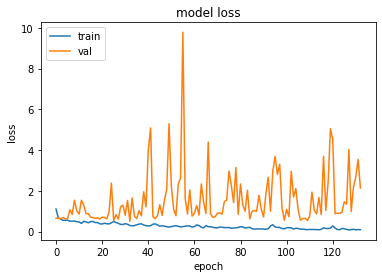

In [17]:
# Model training with earlystopping
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(monitor='val_loss', patience=100, verbose=1, mode='min',restore_best_weights=True)

history = res50model.fit(xTrainBUSI, yTrainBUSI,
              epochs=500,
              verbose=1,
              validation_data = (xTestBUSI, yTestBUSI), batch_size=16,
              callbacks = [es]
             )

# Plot the training and validation losses

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [18]:
preds = res50model.predict(busiTestImages).ravel()
print(preds.shape)

(133,)


In [19]:
# Evaluate model performance on several key metrics
from sklearn.metrics import confusion_matrix
from sklearn import metrics

binPreds = list()

for i in range(len(preds)):
  if preds[i]>0.5:
    binPreds.append(1)
  else:
    binPreds.append(0)
cm = confusion_matrix(binPreds, busiTestLabels)
print(cm)

TP = cm[0][0]
FP = cm[0][1]
FN = cm[1][0]
TN = cm[1][1]

sens = TP / (TP + FN)
spec = TN / (TN + FP)
prec = TP / (TP + FP)
rec = TP / (TP + FN)
f1 = (2*prec*rec)/(prec+rec)
acc = (TP + TN) / (TP + FP + TN + FN)

print('ResNet50 performance')
print('Accuracy: ', acc)
print('Sensitivity: ', sens)
print('Specificity: ', spec)
print('Precision: ', prec)
print('Recall: ', rec)
print('F1 Score: ', f1)

fpr, tpr, thresholds = metrics.roc_curve(busiTestLabels, preds, pos_label=1)
print('AUC: ',metrics.auc(fpr, tpr))

[[66 25]
 [25 17]]
ResNet50 performance
Accuracy:  0.6240601503759399
Sensitivity:  0.7252747252747253
Specificity:  0.40476190476190477
Precision:  0.7252747252747253
Recall:  0.7252747252747253
F1 Score:  0.7252747252747253
AUC:  0.6182626896912612


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 1)]     0         
                                                                 
 densenet121 (Functional)    (None, 7, 7, 1024)        7031232   
                                                                 
 global_average_pooling2d_1   (None, 1024)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_1 (Dense)             (None, 32)                32800     
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 binary_output (Dense)       (None, 1)                 33        
                                                           

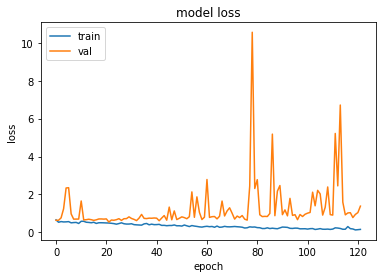

[[84 22]
 [ 7 20]]
DenseNet121 Classification performance.
Accuracy:  0.7819548872180451
Sensitivity:  0.9230769230769231
Specificity:  0.47619047619047616
Precision:  0.7924528301886793
Recall:  0.9230769230769231
F1 Score:  0.8527918781725888
AUC:  0.7732862375719518


In [20]:
# DenseNet121 based classification

model = tf.keras.applications.DenseNet121(include_top=False,
    weights=None,
    input_tensor=None,
    input_shape=(224,224,1))

x = model(inputs)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(32, activation='relu')(x)
x = layers.Dropout(0.3)(x)
binary_output = layers.Dense(1, activation='sigmoid', name='binary_output')(x)


dense121model = tf.keras.Model(inputs = inputs, outputs = binary_output)
print(dense121model.summary())

# Compile model

dense121model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

# Model training with earlystopping

history = dense121model.fit(xTrainBUSI, yTrainBUSI,
              epochs=500,
              verbose=1,
              validation_data = (xTestBUSI, yTestBUSI), batch_size=16,
              callbacks = [es]
             )

# Plot the training and validation losses

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

preds = dense121model.predict(busiTestImages).ravel()

binPreds = list()

for i in range(len(preds)):
  if preds[i]>0.5:
    binPreds.append(1)
  else:
    binPreds.append(0)
cm = confusion_matrix(binPreds, busiTestLabels)
print(cm)

TP = cm[0][0]
FP = cm[0][1]
FN = cm[1][0]
TN = cm[1][1]

sens = TP / (TP + FN)
spec = TN / (TN + FP)
prec = TP / (TP + FP)
rec = TP / (TP + FN)
f1 = (2*prec*rec)/(prec+rec)
acc = (TP + TN) / (TP + FP + TN + FN)

print('DenseNet121 Classification performance.')
print('Accuracy: ', acc)
print('Sensitivity: ', sens)
print('Specificity: ', spec)
print('Precision: ', prec)
print('Recall: ', rec)
print('F1 Score: ', f1)

fpr, tpr, thresholds = metrics.roc_curve(busiTestLabels, preds, pos_label=1)
print('AUC: ',metrics.auc(fpr, tpr))

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 1)]     0         
                                                                 
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802208  
                                                                 
 global_average_pooling2d_2   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_2 (Dense)             (None, 32)                65568     
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 binary_output (Dense)       (None, 1)                 33        
                                                           

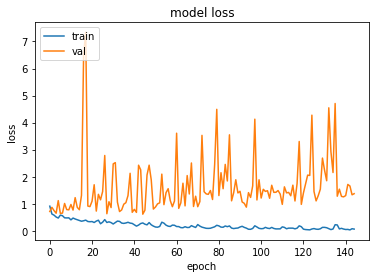

[[52  5]
 [39 37]]
InceptionV3 Model Classification performance.
Accuracy:  0.6691729323308271
Sensitivity:  0.5714285714285714
Specificity:  0.8809523809523809
Precision:  0.9122807017543859
Recall:  0.5714285714285714
F1 Score:  0.7027027027027027
AUC:  0.8413134484563056


In [21]:
# InceptionV3 based classification

model = tf.keras.applications.inception_v3.InceptionV3(include_top=False,
    weights=None,
    input_tensor=None,
    input_shape=(224,224,1))

x = model(inputs)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(32, activation='relu')(x)
x = layers.Dropout(0.3)(x)
binary_output = layers.Dense(1, activation='sigmoid', name='binary_output')(x)


incv3model = tf.keras.Model(inputs = inputs, outputs = binary_output)
print(incv3model.summary())

# Compile model

incv3model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

# Model training with earlystopping

history = incv3model.fit(xTrainBUSI, yTrainBUSI,
              epochs=500,
              verbose=1,
              validation_data = (xTestBUSI, yTestBUSI), batch_size=16,
              callbacks = [es]
             )

# Plot the training and validation losses

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

preds = incv3model.predict(busiTestImages).ravel()

binPreds = list()

for i in range(len(preds)):
  if preds[i]>0.5:
    binPreds.append(1)
  else:
    binPreds.append(0)
cm = confusion_matrix(binPreds, busiTestLabels)
print(cm)

TP = cm[0][0]
FP = cm[0][1]
FN = cm[1][0]
TN = cm[1][1]

sens = TP / (TP + FN)
spec = TN / (TN + FP)
prec = TP / (TP + FP)
rec = TP / (TP + FN)
f1 = (2*prec*rec)/(prec+rec)
acc = (TP + TN) / (TP + FP + TN + FN)

print('InceptionV3 Model Classification performance.')
print('Accuracy: ', acc)
print('Sensitivity: ', sens)
print('Specificity: ', spec)
print('Precision: ', prec)
print('Recall: ', rec)
print('F1 Score: ', f1)

fpr, tpr, thresholds = metrics.roc_curve(busiTestLabels, preds, pos_label=1)
print('AUC: ',metrics.auc(fpr, tpr))

###The individual model prediction results so far are:

ResNet50

1. Accuracy:  0.6240601503759399
2. Sensitivity:  0.7252747252747253
3. Specificity:  0.40476190476190477
4. Precision:  0.7252747252747253
5. Recall:  0.7252747252747253
6. F1 Score:  0.7252747252747253
7. AUC:  0.6182626896912612

InceptionV3

1. Accuracy:  0.6691729323308271
2. Sensitivity:  0.5714285714285714
3. Specificity:  0.8809523809523809
4. Precision:  0.9122807017543859
5. Recall:  0.5714285714285714
6. F1 Score:  0.7027027027027027
7. AUC:  0.8413134484563056

DenseNet121

1. Accuracy:  0.7819548872180451
2. Sensitivity:  0.9230769230769231
3. Specificity:  0.47619047619047616
4. Precision:  0.7924528301886793
5. Recall:  0.9230769230769231
6. F1 Score:  0.8527918781725888
7. AUC:  0.7732862375719518

### Next we try to check whether decision level ensembling of these individual models can do any better or not.

In [22]:
# Get individual model predictions
pred1 = res50model.predict(busiTestImages).ravel()
pred2 = incv3model.predict(busiTestImages).ravel()
pred3 = dense121model.predict(busiTestImages).ravel()

# Get probability averaging based ensembling predictions
preds = np.mean([pred1,pred2,pred3],axis=0)

# Calculate evaluation metrics for ensembled predictions
binPreds = list()

for i in range(len(preds)):
  if preds[i]>0.5:
    binPreds.append(1)
  else:
    binPreds.append(0)
cm = confusion_matrix(binPreds, busiTestLabels)
print(cm)

TP = cm[0][0]
FP = cm[0][1]
FN = cm[1][0]
TN = cm[1][1]

sens = TP / (TP + FN)
spec = TN / (TN + FP)
prec = TP / (TP + FP)
rec = TP / (TP + FN)
f1 = (2*prec*rec)/(prec+rec)
acc = (TP + TN) / (TP + FP + TN + FN)

print('Ensembled Model Classification performance.')
print('Accuracy: ', acc)
print('Sensitivity: ', sens)
print('Specificity: ', spec)
print('Precision: ', prec)
print('Recall: ', rec)
print('F1 Score: ', f1)

fpr, tpr, thresholds = metrics.roc_curve(busiTestLabels, preds, pos_label=1)
print('AUC: ',metrics.auc(fpr, tpr))

[[85 20]
 [ 6 22]]
Ensembled Model Classification performance.
Accuracy:  0.8045112781954887
Sensitivity:  0.9340659340659341
Specificity:  0.5238095238095238
Precision:  0.8095238095238095
Recall:  0.9340659340659341
F1 Score:  0.8673469387755102
AUC:  0.835426478283621


Ensembled Model Classification performance:
1. Accuracy:  0.8045112781954887
2. Sensitivity:  0.9340659340659341
3. Specificity:  0.5238095238095238
4. Precision:  0.8095238095238095
5. Recall:  0.9340659340659341
6. F1 Score:  0.8673469387755102
7. AUC:  0.835426478283621

We observe that in a predicted masked enhanced setting, individual models are not having very good results. Ensembling does however give significant improvements. However, the Ensemble model still does not improve the specificity by a lot.